## Sentiment Classification on Movie Reviews using LSTMs and Keras
In this notebook, we have experimented with Long Short Term Memory(LSTM) Recurrent Neural Networks(RNNs) to perform sentiment classification on movie reviews, using Keras API(https://keras.io/)

### Loading the libraries

In [1]:
# !pip install wordcloud;
from wordcloud import WordCloud,STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.python.keras.layers import SpatialDropout1D
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras import backend as K



### Loading the data


In [2]:
df = pd.read_csv(r"MoviesDataset.csv")
df.head(10)
# shuffle the dataset
df = shuffle(df)
# rearrange the indexes
df.reset_index(inplace=True, drop=True)

### Creating sentiment histogram

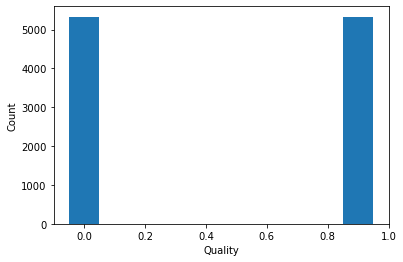

In [3]:
def plot_sentiment_histogram(sentiment): #quality histogram
    unique_vals = df['Sentiment'].sort_values().unique()
    plt.xlabel("Quality")
    plt.ylabel("Count")
    plt.hist(sentiment.values, align='left')
    plt.show()
    
plot_sentiment_histogram(df['Sentiment'])

### split dataset in train and test

In [53]:
X = df['Summary'].values
Y = df['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
max_length = max([len(s.split()) for s in X])
min_length = min([len(s.split()) for s in X])
print(max_length)
print(min_length)

39
1


### Create a dictionary of words

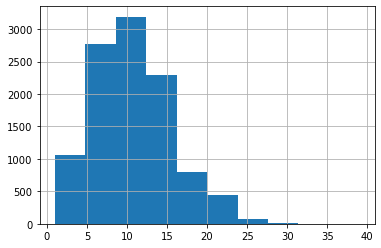

Number of reviews : 819577


In [5]:
reviews_len = [len(x.split()) for x in X]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()
#create a sequence of words
reviews = df['Summary'].values
all_text = ' '.join([c for c in reviews])
reviews_split = all_text.split('\n')

all_text2 = ' '.join(reviews_split)
print('Number of reviews :', len(all_text2))
# create a list of words
words = all_text2.split()  # Count all the words using Counter Method
# Build a dictionary that maps words to integers
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(9000)

### Get unique words

In [6]:
unique = []
for word in words:
    if word not in unique:
        unique.append(word)

#sort
unique.sort()
len(unique)

16319

### Create wordcloud illustration
For sentiment analysis it is always useful to get the most frequent words of the dataset. For this purpose, we will create a wordcloud to get the top 500 most frequent words.A worldcloud is a technique for visualising frequent words in a text where the size of the words represents their frequency.

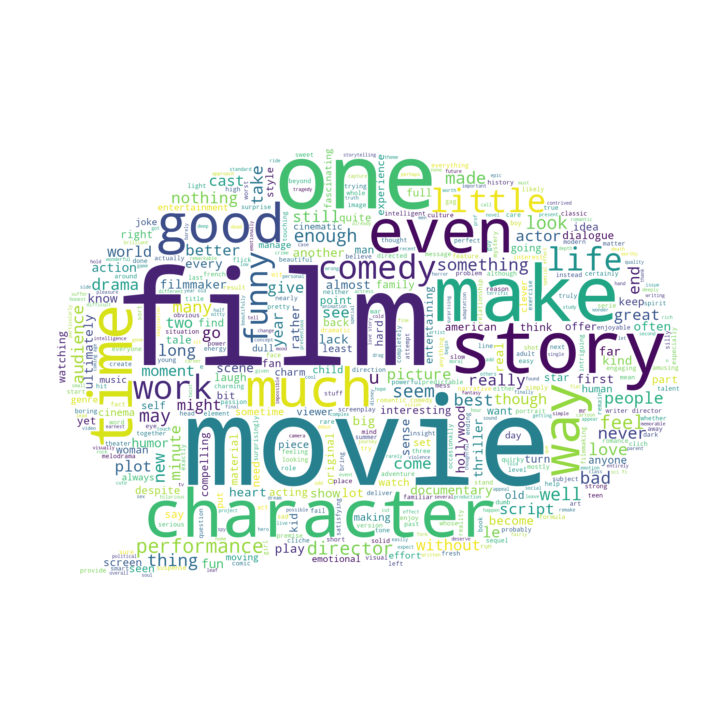

In [54]:
import numpy as np
from PIL import Image
mask = np.array(Image.open('comment.png'))
# limit the word count and set the stopwords
wordcount = 500
stopwords = set(STOPWORDS)
stopwords.add("br")

# setup, generate and save the word cloud image to a file
wc = WordCloud(
               random_state=1,            
               background_color="white",
               width=500, height=400,
               mask = mask,
               max_words=wordcount,
               stopwords=stopwords)
wc.generate(all_text2)
wc.to_file("WordCloud.png")

# show the wordcloud as output
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.tight_layout()  


In [52]:
total_words = len(words)
sorted_words = count_words.most_common(100)
print(sorted_words)


[('film', 1780), ('movie', 1602), ('one', 794), ('like', 740), ('story', 540), ('make', 532), ('character', 494), ('time', 479), ('good', 424), ('comedy', 415), ('much', 388), ('even', 386), ('way', 338), ('well', 334), ('director', 331), ('work', 330), ('performance', 326), ('life', 315), ('little', 307), ('funny', 294), ('feel', 285), ('get', 274), ('enough', 268), ('never', 263), ('u', 254), ('bad', 248), ('may', 245), ('love', 244), ('best', 243), ('year', 241), ('thing', 241), ('look', 232), ('would', 232), ('made', 222), ('take', 219), ('come', 215), ('new', 211), ('drama', 205), ('action', 204), ('something', 202), ('could', 200), ('audience', 199), ('really', 197), ('see', 196), ('two', 195), ('minute', 192), ('plot', 191), ('go', 185), ('still', 184), ('long', 184), ('many', 183), ('old', 180), ('every', 179), ('big', 176), ('people', 176), ('first', 175), ('nothing', 175), ('better', 173), ('end', 172), ('give', 172), ('fun', 169), ('without', 167), ('great', 166), ('picture'

### Tokenizing sentences, creating and padding sequences
* `Tokenize`: divides a sentence into a list of words, to implement this we are using the TensorFlow (Keras) **Tokenizer**   class and we keep only the 10.000 most frequent words.
* `Create Vocabulary`: creates the vocabulary index based on word frequency. It is a word to index dictionary, so every word gets a unique integer value, lower integer means more frequent word. This was implemented with the **fit_on_texts** method of keras.
* `Words to integers`: takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. This was implemented with the **text_to_sequences** method of Keras.
* `Padding sequences`: Input data for our model needs to be of the same length, which is not happening in our dataset. For this reason we need to use padding, a method used to ensure that all sequence in dataset have the same length. This was implemented with the **pad-sequences** method of keras.

In [24]:
X = df['Summary'].values
Y = df['Sentiment'].values

max_seq_length = 30
# tokenize
tokenizer = Tokenizer(num_words=10000)
# Create the vocabulary index based on word frequency
tokenizer.fit_on_texts(X)
# number of the unique words based on the number of elements in this dictionary
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % vocab_size)

# assign an integer to each word
x_train_tokens = tokenizer.texts_to_sequences(X_train)
x_test_tokens = tokenizer.texts_to_sequences(X_test)

# pad all our reviews to a specific length
X_train = pad_sequences(x_train_tokens, maxlen=max_seq_length)
X_test = pad_sequences(x_test_tokens, maxlen=max_seq_length)


Found 16320 unique tokens.


In [25]:
MAX_SEQUENCE_LENGTH = 30
print(vocab_size)
EMBEDDING_DIM = 16


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

16320


### Build model

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=True, batch_size=32)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 16)            261120    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                13400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 274,571
Trainable params: 274,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
234/234 [==============================] - 8s 36ms/step - loss: 0.6909 - accuracy: 0.5176 - f1_m: 0.5348

### Precision, recall, f1-score and accuracy

In [27]:
print("F1-score")
print(f1_score)
print("Precision")
print(precision)
print("Recall")
print(recall)

F1-score
0.7369166612625122
Precision
0.7189660668373108
Recall
0.7665362358093262


### Test model

In [28]:
test_word = "This is a bad bad movie"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw, maxlen=30)
prediction = int(model.predict(tw).round().item())
print(Y[prediction])

test_word = "This film is terrible"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw, maxlen=30)
prediction = int(model.predict(tw).round().item())
print(Y[prediction])

test_word = "This film is great"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw, maxlen=30)
prediction = int(model.predict(tw).round().item())
print(Y[prediction])

0
0
1
